# Segementação por Watershed

In [1]:
import cv2
import numpy as np

from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

import matplotlib.pyplot as plt


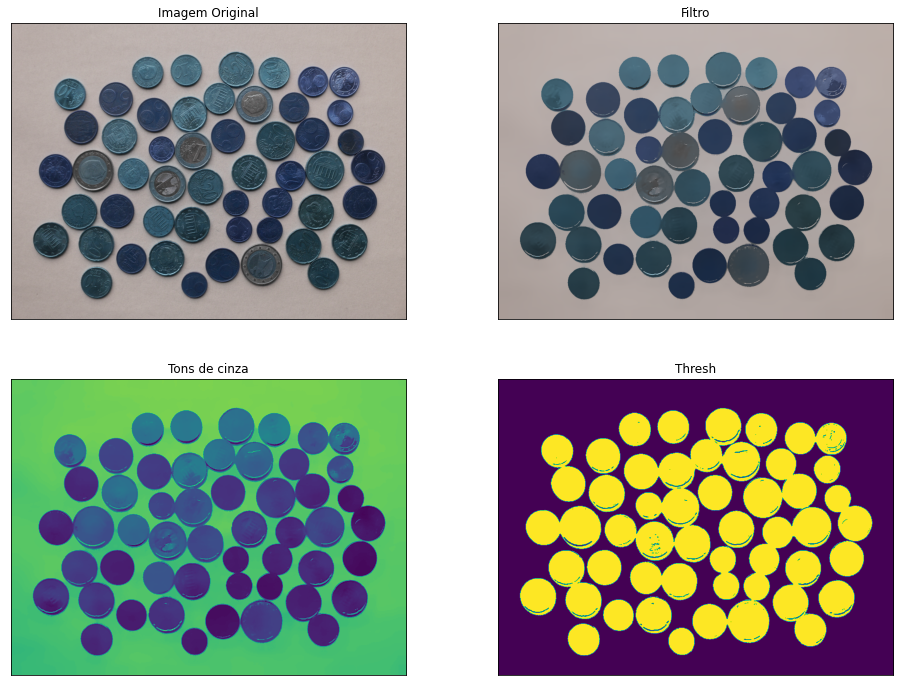

In [2]:
img = cv2.imread('coins.jpg')

# filtro para preservação de borda de imagem
# frequentemente usado para remover ruído antes da segmentação por watershed
filtro = cv2.pyrMeanShiftFiltering(img, 20, 40)

gray = cv2.cvtColor(filtro, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

titulos = ['Imagem Original', 'Filtro', 'Tons de cinza', 'Thresh']
imagens = [img, filtro, gray, thresh]

fig = plt.gcf()
fig.set_size_inches(16, 12)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(imagens[i])
    plt.title(titulos[i]) 
    plt.xticks([]),plt.yticks([])     
plt.show()

# Preenchimento dos buracos na  imagem binaria


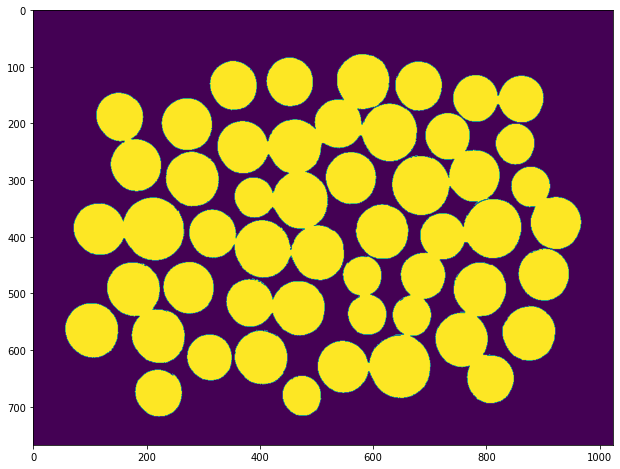

In [3]:
contornos, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
buracos = []
for con in contornos:
    area = cv2.contourArea(con)
    if area < 1000:
        buracos.append(con)
cv2.drawContours(thresh, buracos, -1, 255, -1)

fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.imshow(thresh)

## Calculo da distância da transformação

` ndi.distance_transform_edt`

* **src** − imagem de entrada.
* **dst** − imagem de saída.
* **distanceType** − Uma variável que representa o tipo de transformação de distância
* **maskSize** − Uma variável que representa o tamanho da máscara (geralmente é definida com um valor 3)

Para o parâmetro distanceType, podemos escolher vários tipos diferentes de transformada de distância. Em nosso código, estamos usando uma distância euclidiana simples. No exemplo a seguir, você pode ver alguns outros tipos de transformação de distância.

* DIST_USER – distância definida pelo usuário
* DIST_L1 – $(distância = |x_{1}-x_{2}|+| y_{1}-y_{2} \mid)$
* DIST_L2 – a distância euclidiana simples
* DIST_C – $(distância = max(|x_{1}-x_{2}|,| y_{1}-y_{2} \mid))$

In [4]:
dist = ndi.distance_transform_edt(thresh, cv2.DIST_L2)
dist_visual = dist.copy()

### Encontrando pontos de máximos locais

O próximo passo é encontrar as coordenadas dos picos (máximos locais) das áreas brancas na imagem. Para isso, usaremos a função `peak_local_max()`da biblioteca Scikit-image. Vamos aplicar esta função à nossa `distance_transform` imagem e a saída nos dará os marcadores que serão usados na função watershed.

In [5]:
local_max = peak_local_max(dist, indices=False, min_distance=20, labels=thresh)

### Marcando os Labels

O próximo passo é rotular marcadores para a função `watershed`. Para isso, usaremos a função  `ndi.label()` da biblioteca SciPy.

Esta função consiste em um parâmetro `input` que é um objeto tipo array a ser rotulado. Quaisquer valores diferentes de zero neste parâmetro são considerados como características e os valores zero são considerados como plano de fundo. Nesse caso usaremos as coordenadas do máximo local calculado.

Em seguida, a função `ndi.label()` rotulará aleatoriamente todos os máximos locais com diferentes valores positivos a partir de 1. Assim, caso tenhamos 10 objetos na imagem, cada um deles será rotulado com um valor de 1 a 10.

In [6]:
markers = ndi.label(local_max, structure=np.ones((3, 3)))[0]

### Watershed

A etapa final é aplicar a `skimage.segmentation.watershed()` função da biblioteca Scikit-image. 

Como parâmetros, precisamos passar nossa imagem de transformação de distância invertida e os marcadores que calculamos na linha de código anterior. 

Como o algoritmo de watershed assume que nossos marcadores representam mínimos locais, precisamos inverter nossa imagem de transformada de distância. Dessa forma, pixels claros representarão elevações altas, enquanto pixels escuros representarão elevações baixas para a transformada de bacia.

In [7]:
labels = watershed(-dist, markers, mask=thresh)

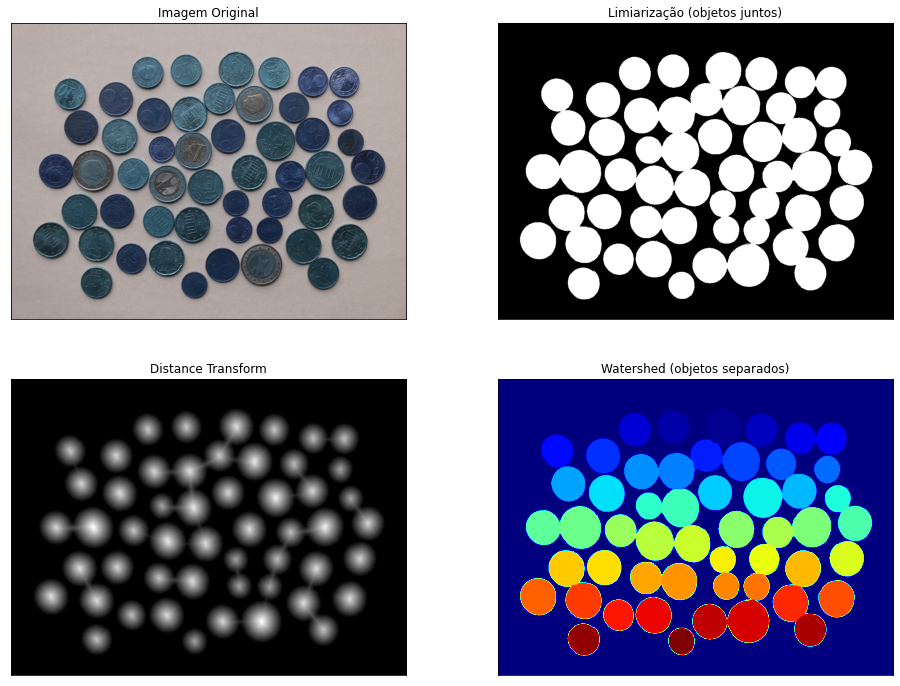

In [8]:
titulos = ['Imagem Original', 'Limiarização (objetos juntos)', 'Distance Transform', 'Watershed (objetos separados)']
imagens = [img, thresh, dist_visual, labels]

fig = plt.gcf()
fig.set_size_inches(16, 12)  
for i in range(4):
    plt.subplot(2,2,i+1)
    # condição para colocar colormap jet apenas pra imagem com o resultado do watershed
    if (i == 3):
        cmap = "jet"
    else:
        cmap = "gray"
    plt.imshow(imagens[i], cmap)
    plt.title(titulos[i]) 
    plt.xticks([]),plt.yticks([])     
plt.show()